# Local Invariant Features
## Computer Vision and Image Processing - Lab Session 5 - Exercises
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Alex Costanzino, alex.costanzino@unibo.it - Iacopo Curti, iacopo.curti2@unibo.it

### Exercise 1: Object Detection
Given a query image ('ex/bishop.jpg') detect the object in the scene images: 'scene1.jpg', 'scene2.jpg' and 'scene3.jpg'.

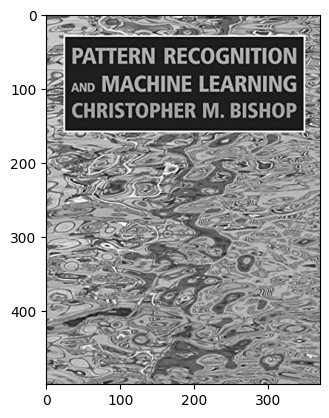

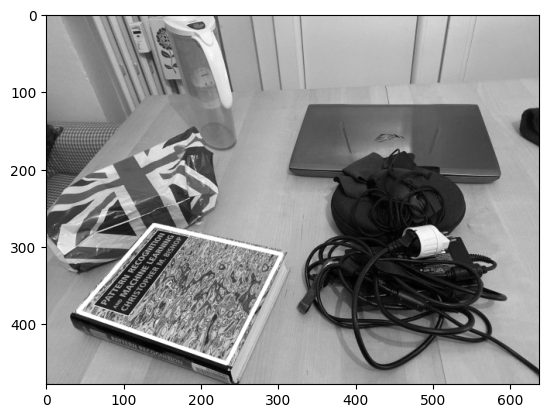

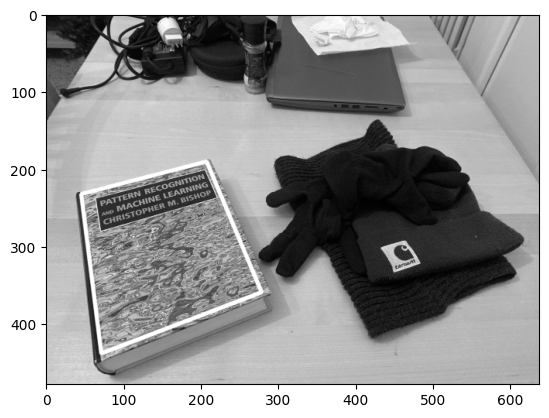

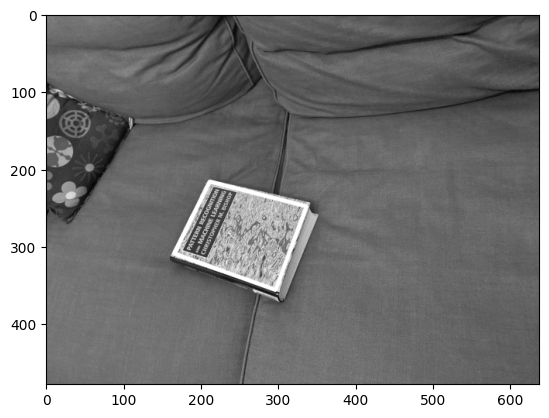

(True,
 [1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1])

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img_query = cv2.imread('ex/bishop.jpg', 0)
plt.imshow(img_query, cmap='gray',vmin=0, vmax=255)
plt.show()
scene1 = cv2.imread('ex/scene1.jpg', 0)
# plt.imshow(scene1, cmap='gray',vmin=0,vmax=255)
# plt.show()
scene2 = cv2.imread('ex/scene2.jpg', 0)
# plt.imshow(scene2, cmap='gray',vmin=0,vmax=255)
# plt.show()
scene3 = cv2.imread('ex/scene3.jpg', 0)
# plt.imshow(scene3, cmap='gray',vmin=0,vmax=255)
# plt.show()

### detect keypoints ###

sift = cv2.SIFT_create()
kp_query = sift.detect(img_query)
kp_scene1 = sift.detect(scene1)
kp_scene2 = sift.detect(scene2)
kp_scene3 = sift.detect(scene3)

### compute descriptors ###

kp_query, desc_query = sift.compute(img_query, kp_query)
kp_scene1, desc_scene1 = sift.compute(scene1, kp_scene1)
kp_scene2, desc_scene2 = sift.compute(scene2, kp_scene2)
kp_scene3, desc_scene3 = sift.compute(scene3, kp_scene3)
# print(desc_query.shape, desc_scene1.shape, desc_scene2.shape, desc_scene3.shape)

### find correspondences ###

# parametri per l'algoritmo di ricerca
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
# Matching and finding the 2 closest elements for each query descriptor.
matches_scene1 = flann.knnMatch(desc_query, desc_scene1, k=2)
matches_scene2 = flann.knnMatch(desc_query, desc_scene2, k=2)
matches_scene3 = flann.knnMatch(desc_query, desc_scene3, k=2)
# filter bad matches

def filter_bad_matches(matches):
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    return good
    
good_scene1 = filter_bad_matches(matches_scene1)
good_scene2 = filter_bad_matches(matches_scene2)
good_scene3 = filter_bad_matches(matches_scene3)

### Detect the object

def find_object(kp_query, kp_train, good_matches, img_query, img_train):
    # Checking if we found enough matching
    MIN_MATCH_COUNT = 10
    if len(good_matches)>MIN_MATCH_COUNT:
        # building the corrspondences arrays of good matches
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
        # Using RANSAC to estimate a robust homography. 
        # It returns the homography M and a mask for the discarded points
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        # Mask of discarded point used in visualization
        matchesMask = mask.ravel().tolist() # ravel è sinonimo di unravel, trasforma l'array numpy 2d (n, 1), in un array 1d (n,)
        # Corners of the query image
        h,w = img_query.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        # Projecting the corners into the train image
        dst = cv2.perspectiveTransform(pts,M)
        # Drawing the bounding box
        img_train = cv2.polylines(img_train, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
        plt.imshow(img_train, "gray")
        plt.show()
        return True, matchesMask
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
        return False, matchesMask

find_object(kp_query, kp_scene1, good_scene1, img_query, scene1)
find_object(kp_query, kp_scene2, good_scene2, img_query, scene2)
find_object(kp_query, kp_scene3, good_scene3, img_query, scene3)

### Exercise 2: Image Search
Given a query image ('ex/bishop.jpg') and several train images ('ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg', 'ex/scene4.jpg', 'ex/scene5.jpg') implement an image search algorithm to find which images contain the query object.

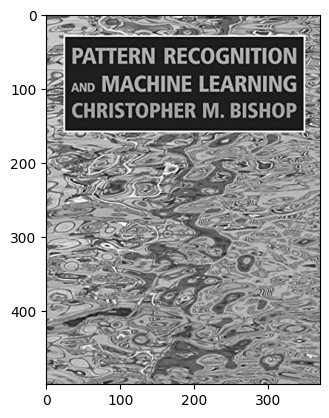

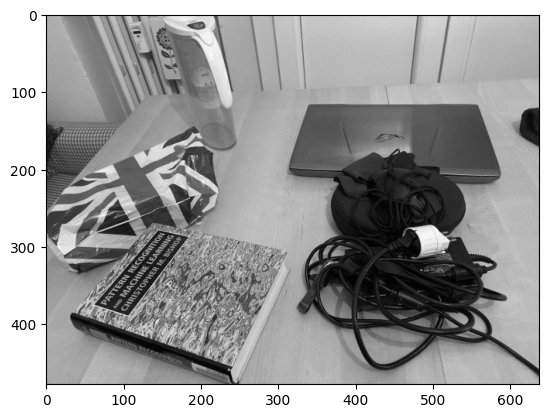

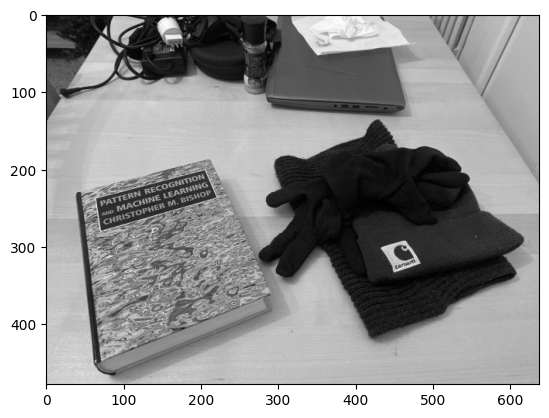

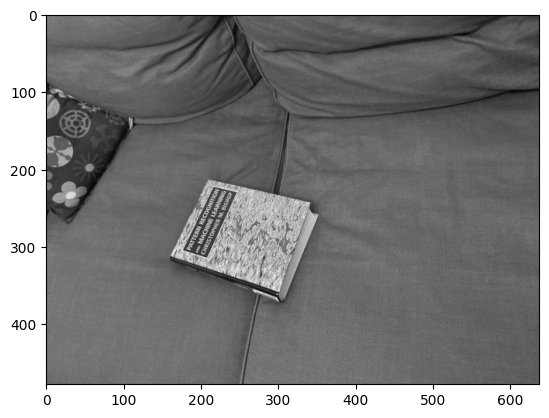

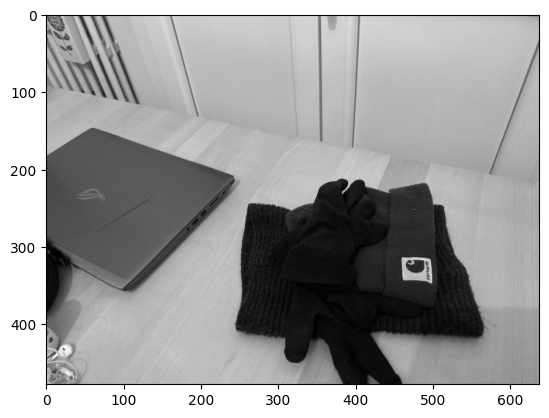

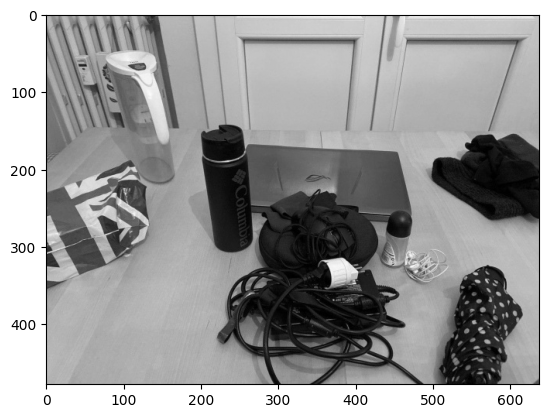

True
True
True
False
False


In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img_query = cv2.imread('ex/bishop.jpg', 0)
scene1 = cv2.imread('ex/scene1.jpg', 0)
scene2 = cv2.imread('ex/scene2.jpg', 0)
scene3 = cv2.imread('ex/scene3.jpg', 0)
scene4 = cv2.imread('ex/scene4.jpg', 0)
scene5 = cv2.imread('ex/scene5.jpg', 0)
plt.imshow(img_query, cmap='gray',vmin=0, vmax=255)
plt.show()
plt.imshow(scene1, cmap='gray',vmin=0,vmax=255)
plt.show()
plt.imshow(scene2, cmap='gray',vmin=0,vmax=255)
plt.show()
plt.imshow(scene3, cmap='gray',vmin=0,vmax=255)
plt.show()
plt.imshow(scene4, cmap='gray',vmin=0,vmax=255)
plt.show()
plt.imshow(scene5, cmap='gray',vmin=0,vmax=255)
plt.show()

def detect_instance(img_query, img_train):
    sift = cv2.SIFT_create()
    # detect keypoints
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train)
    # compute descriptors
    kp_query, desc_query = sift.compute(img_query, kp_query)
    kp_train, desc_train = sift.compute(img_train, kp_train)
    # find correspondences 
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc_query, desc_train, k=2)
    # filtriamo le correspondenze trovate
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)
            
    MIN_MATCH_COUNT = 10
    conta_match = 0
    
    if len(good_matches)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
        # L'omografia non mi serve, la uso per filtrare con RANSAC ulteriori match sbagliati (quelli che portano ad avere un'omografia con reprojection error troppo alto) 
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        # Mask of discarded point used in visualization
        matchesMask = mask.ravel().tolist() # ravel è sinonimo di unravel, trasforma l'array numpy 2d (n, 1), in un array 1d (n,)
        for vote in mask:
            if vote == 1:
                conta_match += 1
        if conta_match > MIN_MATCH_COUNT:
            return True, matchesMask
        else:
            return False, matchesMask
    else:
        print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
        return False, None
    

found1, matches_mask1 = detect_instance(img_query, scene1)
print(found1)
found2, matches_mask2 = detect_instance(img_query, scene2)
print(found2)
found3, matches_mask3 = detect_instance(img_query, scene3)
print(found3)
found4, matches_mask4 = detect_instance(img_query, scene4)
print(found4)
found5, matches_mask5 = detect_instance(img_query, scene5)
print(found5)

### Exercise 3: Mosaicing (aka Panorama Stitching)

Given two images stitch them in a single image. 

Test it on the couples:

- 'ex/bologna_left.jpg' and 'ex/bologna_right.jpg'
- 'ex/bologna_logo_left.jpg' and 'ex/bologna_logo_right.jpg'
- 'ex/front_gallery_left.jpg' and 'ex/front_gallery_right.jpg'
- 'ex/gallery_left.jpg' and 'ex/gallery_right.jpg'
- 'ex/wall_left.jpg' and 'ex/wall_right.jpg'

_Tips:_ 
* Find correspondences between the images within each couple
* Find an homography
* Warp one image and restore values for the other image 

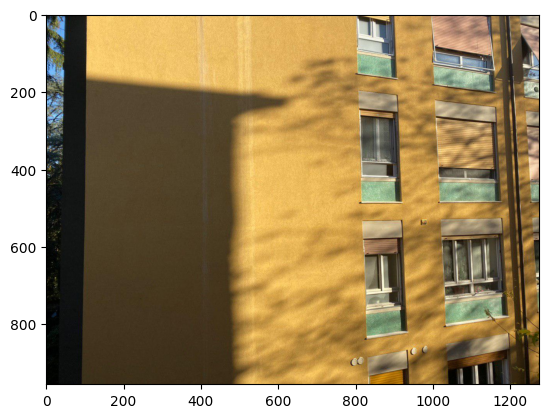

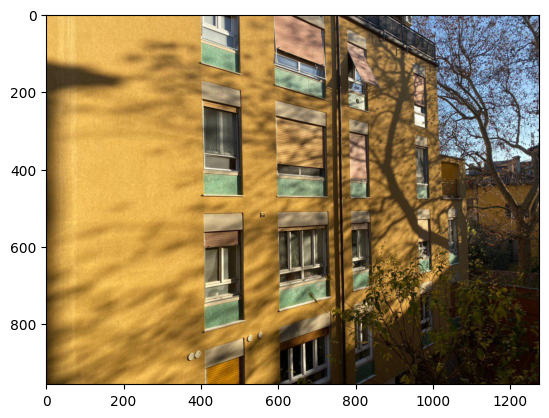

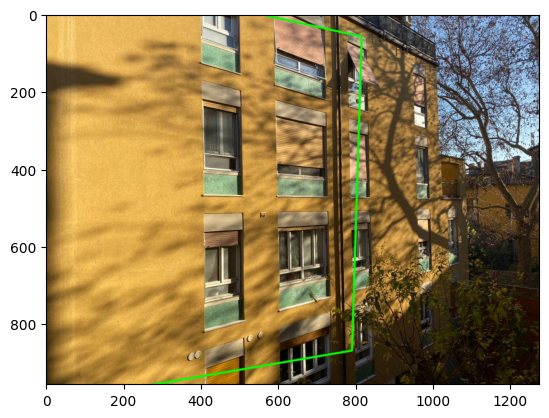

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img_query = cv2.imread('ex/panorama_left_rgb.jpg')
img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)
img_train = cv2.imread('ex/panorama_right_rgb.jpg')
img_train = cv2.cvtColor(img_train, cv2.COLOR_BGR2RGB)
plt.imshow(img_query)
plt.show()
plt.imshow(img_train)
plt.show()

def find_matches(img_query, img_train):
    sift = cv2.SIFT_create()
    
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train)
    
    kp_query, desc_query = sift.compute(img_query, kp_query)
    kp_train, desc_train = sift.compute(img_train, kp_train)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc_query, desc_train, k=2)
    
    return matches, kp_query, kp_train

def filter_bad_matches(matches):
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    return good

def estimate_homography(kp_query, kp_train, good_matches):
    MIN_MATCH_COUNT = 10
    if len(good_matches)>MIN_MATCH_COUNT:
        # building the corrspondences arrays of good matches
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
        # Using RANSAC to estimate a robust homography. 
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return M, mask
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        return None, None

matches, kp_query, kp_train = find_matches(img_query, img_train)
good_matches = filter_bad_matches(matches)
H, mask = estimate_homography(kp_query, kp_train, good_matches)

# Ora che abbiamo l'omografia, trovare le coordinate di img_query dentro a img_train

# Corners of the images
h_q, w_q, _ = img_query.shape
h_t, w_t, _ = img_train.shape
corners_q = np.float32([[0, 0], [0, h_q-1], [w_q-1, h_q-1], [w_q-1,0]]).reshape(-1,1,2)
corners_t = np.float32([[0, 0], [0, h_t-1], [w_t-1, h_t-1], [w_t-1,0]]).reshape(-1,1,2)

transformed_corners_q = cv2.perspectiveTransform(corners_q, H)

# Disegno dove img_query finisce in img_train
img_train = cv2.polylines(img_train, [np.int32(transformed_corners_q)], True, (0, 255, 0), 3, cv2.LINE_AA)
plt.imshow(img_train)
plt.show()

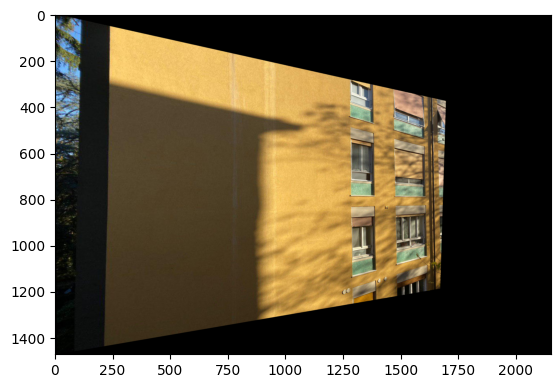

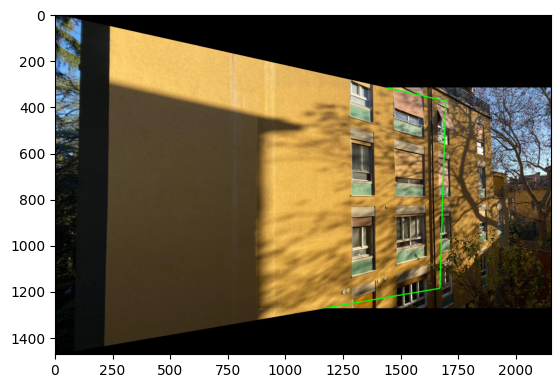

In [6]:
# Ora ho le pixel coordinates degli angoli di entrambe le immagini
# ed ho anche l'omografia per fare il warping prospettico della prima immagine nella seconda

# Chiaramente, alcuni angoli della prima immagine hanno coordinate negative rispetto 
# all'origine della seconda immagine (nella seconda immagine quegl'angoli sono assenti).
# Dobbiamo costruire una nuova immagine grande abbastanza da contenere entrambe le immagini
# e definire una nuova origine per le pixel coordinates in questa nuova immagine 

all_corners = np.concatenate((transformed_corners_q, corners_t), axis=0)
x_min, y_min = np.int32(all_corners.min(axis=0).ravel()) # ho bisogno che siano degli np.int32
x_max, y_max = np.int32(all_corners.max(axis=0).ravel()) # ho bisgono che siano degli np.int32
new_w, new_h = (x_max-x_min)+1, (y_max-y_min)+1 # ricorda il +1 necessario dato che sto facendo la differenza di indici (pensa a 3999-0; sono 4000 elementi non 3999) 

# ora ho le dimensioni della nuova immagine, tuttavia se applico solamente l'omografia alla prima immagine
# mi rimangono le coordinate negative dei corners e quindi il warping che ottengo risulta tagliato.
# Oltre al warping che mi porta la prima immagine nella seconda, ho bisogno di un ulteriore warping che mi
# trasla il risultato del primo warping in maniera tale da non avere più coordinate negative.
# In altre parole ho bisogno di una traslazione!

# devo traslare in maniera tale da risposizionare x_min e y_min a 0
translation = [-x_min, -y_min] 
# Matrice di traslazione (pensa al risultato di T*homogeneus_coordinate_img)
T = np.array([
    [1, 0, translation[0]],
    [0, 1, translation[1]],
    [0, 0, 1]
])
# Warping, prima proietto e poi traslo
result = cv2.warpPerspective(img_query, T @ H, (new_w, new_h)) # @ == np.matmul()
plt.imshow(result)
plt.show()

# Infine, stitching dell'immagine di train
row_begin_train = translation[1]
column_begin_train = translation[0]
result[row_begin_train:(row_begin_train+h_t), column_begin_train:(column_begin_train+w_t)] = img_train
plt.imshow(result)
plt.show()

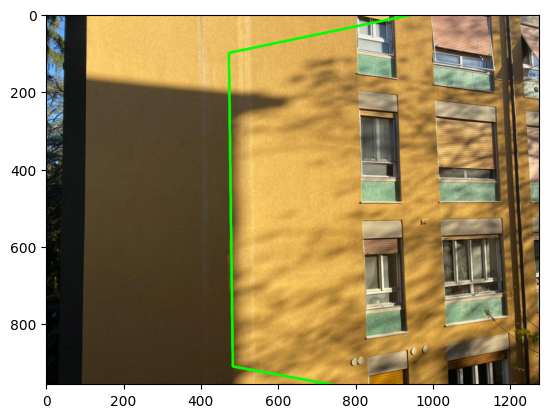

2163 1455


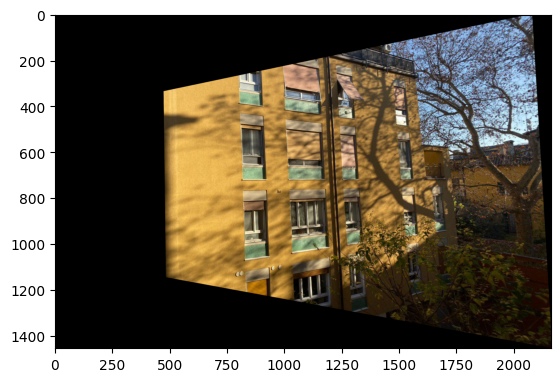

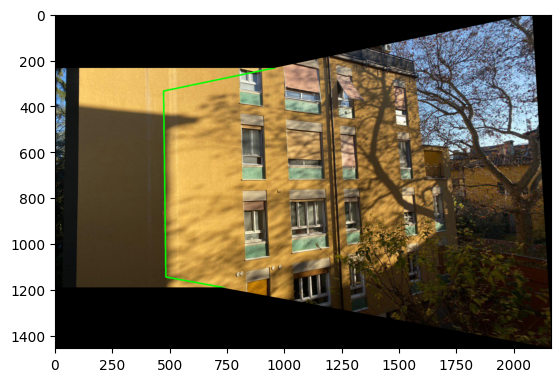

In [43]:
###
### Oppure posso mappare gli angoli dell'immagine di destra in quella di sinistra
### in modo da non avere coordinate negative, ed eliminando la necessità di traslazioni
### 
### ... nevermind, le traslazioni sembrano servire comunque 
###

transformed_corners_t = cv2.perspectiveTransform(corners_t, np.linalg.inv(H))
# Disegno dove img_query finisce in img_train
img_query = cv2.polylines(img_query, [np.int32(transformed_corners_t)], True, (0, 255, 0), 3, cv2.LINE_AA)
plt.imshow(img_query)
plt.show()

all_corners = np.concatenate((transformed_corners_t, corners_q), axis=0)
x_min, y_min = np.int32(all_corners.min(axis=0).ravel()) # ho bisgono che siano degli np.int32
x_max, y_max = np.int32(all_corners.max(axis=0).ravel()) # ho bisgono che siano degli np.int32
new_w, new_h = (x_max-x_min)+1, (y_max-y_min)+1 # ricorda il +1 necessario dato che sto facendo la differenza di indici (pensa a 3999-0) 
# new_w, new_h = (x_max)+1, (y_max)+1 # ricorda il +1 necessario dato che sto facendo la differenza di indici (pensa a 3999-0) 

print(new_w, new_h)

# Warping
translation = [-x_min, -y_min] 
# Matrice di traslazione (pensa al risultato di T*homogeneus_coordinate_img)
T = np.array([
    [1, 0, translation[0]],
    [0, 1, translation[1]],
    [0, 0, 1]
])

result = cv2.warpPerspective(img_train, T @ np.linalg.inv(H), (new_w, new_h))
plt.imshow(result)
plt.show()

# Infine, stitching dell'immagine di train
row_begin_query = translation[1]
column_begin_query = translation[0]
result[row_begin_query:(row_begin_query+h_q), column_begin_query:(column_begin_query+w_q)] = img_query
plt.imshow(result)
plt.show()

### Exercise 4: Augmentated Reality 
Given an image ('ex/stregatto.jpg') implement an augmented reality algorithm to project the image into the surface of the query object ('ex/bishop.jpg).

Moreover, restore the values of the original scene image instead of black pixels obtained with warping. 

Test it on scene images 'ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg'.

_Expected Results_:

<img src="LabSession5Images/ar_ex.png" width="400">

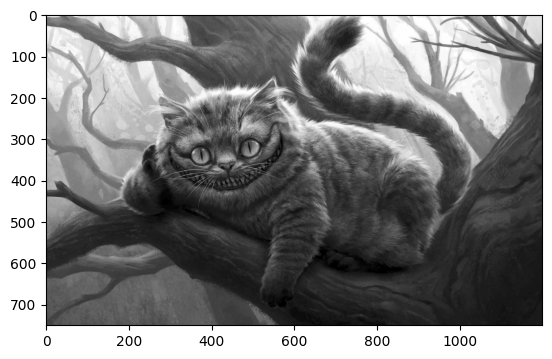

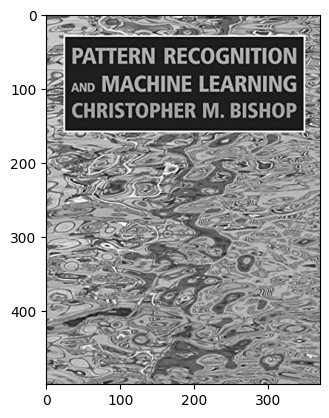

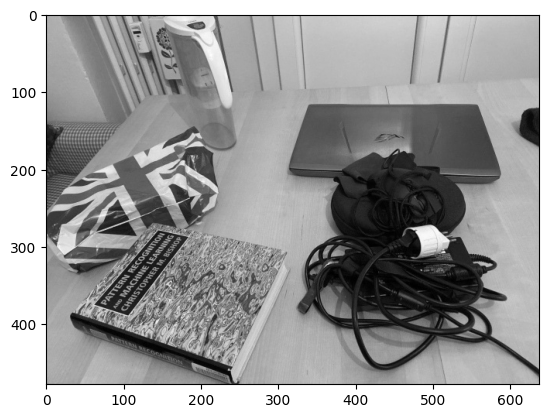

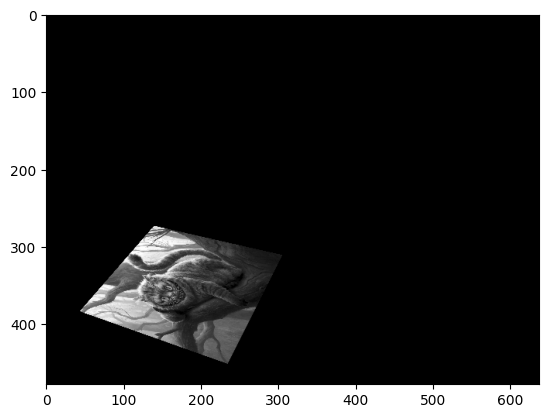

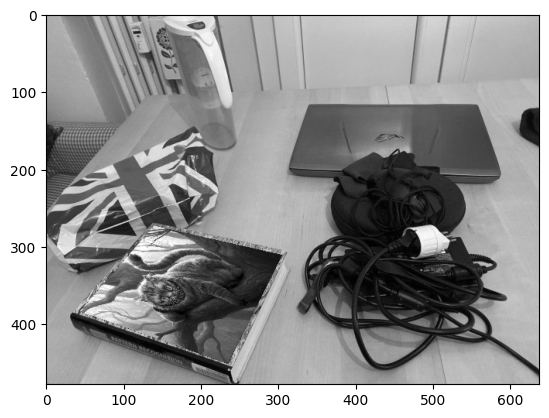

(True,
 [1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1])

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def find_matches(img_query, img_train):
    sift = cv2.SIFT_create()
    
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train)
    
    kp_query, desc_query = sift.compute(img_query, kp_query)
    kp_train, desc_train = sift.compute(img_train, kp_train)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc_query, desc_train, k=2)
    
    return matches, kp_query, kp_train

def filter_bad_matches(matches):
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    return good

def draw_over_detection(kp_query, kp_train, good_matches, query_img, train_img, ar_img):
    MIN_MATCH_COUNT = 10
    if len(good_matches)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
        # Using RANSAC to estimate a robust homography. 
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        
        # Corners and dimensions
        h_q, w_q = query_img.shape
        corners_q = np.float32([ [0,0],[0,h_q-1],[w_q-1,h_q-1],[w_q-1,0] ]).reshape(-1,1,2)
        h_ar, w_ar = ar_img.shape
        corners_ar = np.float32([ [0,0],[0,h_ar-1],[w_ar-1,h_ar-1],[w_ar-1,0] ]).reshape(-1,1,2)
        h_t, w_t = train_img.shape

        # Projecting the corners of the query image into the train image
        remapped_corners_q = cv2.perspectiveTransform(corners_q, H)
        # NB: se la ar_img avesse le stesse dimensioni della query_img,
        # allora potremmo usare direttamente l'omografia H. Siccome questo
        # non è vero, se facessimo il warping con H otteremmo dello stretching
        # e l'ar_img non coprirebbe correttamente la detection.
        # Dobbiamo quindi per forza stimare una seconda omografia che mi mappa 
        # corner_ar nei corner della detection
        M = cv2.getPerspectiveTransform(corners_ar, remapped_corners_q)
        warped = cv2.warpPerspective(ar_img, M, (w_t, h_t))
        plt.imshow(warped, "gray")
        plt.show()

        # Warp a white mask to understand what are the black pixels
        white = np.ones([h_ar, w_ar],dtype=np.uint8)*255
        warp_mask = cv2.warpPerspective(white, M, (w_t, h_t))
        warp_mask = (warp_mask == 0)
        # Restore previous values
        warped[warp_mask] = train_img[warp_mask]
        plt.imshow(warped, "gray")
        plt.show()
        
        return True, matchesMask
    else:
        print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
        return False, None

    
ar_img = cv2.imread('ex/stregatto.jpg', 0)
query_img = cv2.imread('ex/bishop.jpg', 0)
train_img = cv2.imread('ex/scene1.jpg', 0)
plt.imshow(ar_img, "gray")
plt.show()
plt.imshow(query_img, "gray")
plt.show()
plt.imshow(train_img, "gray")
plt.show()

matches, kp_query, kp_train = find_matches(query_img, train_img)
good_matches = filter_bad_matches(matches)
draw_over_detection(kp_query, kp_train, good_matches, query_img, train_img, ar_img)
